# Personality Insight Profiles Generation

*In this notebook cleaned text data is fed to Watson Personality Insight; then, the output of the service is parsed and proper dataframes are formed from json outputs.*


***On Watson Personality Insight.***
The IBM Watson&trade; Personality Insights service enables applications to derive insights from social media, enterprise data, or other digital communications. The service uses linguistic analytics to infer individuals’ intrinsic personality characteristics, including Big Five, Needs, and Values, from digital communications such as email, text messages, tweets, and forum posts.
- - -

***Docs at:***
1. http://watson-developer-cloud.github.io/python-sdk/v3.0.1/apis/ibm_watson.personality_insights_v3.html
2. https://cloud.ibm.com/docs/services/personality-insights?topic=personality-insights-input

---
***Other options to investigate:***
1. https://www.g2.com/products/ibm-watson-personality-insights/competitors/alternatives

- - -
- - -

## Settings

In [31]:
!pip install ibm_watson

Requirement already up-to-date: ibm_watson in /opt/conda/envs/Python36/lib/python3.6/site-packages (4.4.1)


In [2]:
from ibm_watson import PersonalityInsightsV3
import json
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='***************', project_access_token='*********************')
pc = project.project_context


## Connecting Cloud Object Storage (COS)

In [4]:
filename = 'twitter_main.csv'

In [5]:
f = project.get_file(filename)
df = pd.read_csv(f)

In [6]:
df.head()

UID                                               Text
0   89168924  Radio stations and TV channels have changed th...
1   74580436  On Tuesday, June 2nd, Apple Music will observe...
2   52536879  Little Richard receives the Merit Award at the...
3   17243213  In response to George Floyd's death––the death...
4  278662460  3 years ago today, BTS_twt accepted their firs...

## Checking NULL Fields

In [7]:
ch = []
for index, row in df.iterrows():
    try:
        ch.append(len(row['Text']))        
    except Exception:
        print(index, ":  ", row['Text'])

415 :   nan
810 :   nan
4716 :   nan


In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
print("Any na left ?")
df[df.isna() == True].count()

Any na left ?


UID     0
Text    0
dtype: int64

## Authorization in Personality Insight Service

In [24]:
url = "https://gateway-fra.watsonplatform.net/personality-insights/api"
apikey = "***********************************"

# # Authentication via IAM
authenticator = IAMAuthenticator(apikey)
service = PersonalityInsightsV3(
    version='2017-10-13',
    authenticator=authenticator)
service.set_service_url(url)

## Creating dataframe of profiles


In [25]:
def get_profile_element(profile, element, output_name=None, plot=True, return_df=True):
    
    av = ['personality', 'needs', 'values']
    #assert element in av, "can't visualize this element"
    value_field = 'percentile'
    if not output_name:
        output_name = element
        
    ex_dict = {el['name']:el[value_field] for el in profile[element]}
    
    df = pd.DataFrame.from_dict(ex_dict, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={"index": output_name, 0: "scores"}, inplace=True)
    
    if plot:
        plt.figure(figsize=(15, 7))
        sns.barplot(y='scores', x=output_name, data=df);
        plt.show()
        
    if return_df: return df

In [39]:
def profile_elements_keys(text):
    
    profile = service.profile(
    text,
    'application/json',
    raw_scores=True,
    consumption_preferences=False).get_result()
    print("hey  ",profile['warnings'])
    
    av = ['personality', 'needs', 'values']
    outs = {}
    for element in av:
        ex_dict = {el['name']:el['percentile'] for el in profile[element]}
        outs[element] = ex_dict.keys()
    
    return outs

In [40]:
def generate_profile_df(profile, element):
        
    ex_dict = {el['name']:el['percentile'] for el in profile[element]}
    
    return pd.DataFrame.from_records(ex_dict, index=[0], columns=ex_dict.keys())

In [41]:
def text2profile(text, profile_elements = ['personality', 'needs', 'values']):
    try:
        profile = service.profile(
            text,
            'application/json',
            raw_scores=True,
            consumption_preferences=False).get_result()

        result = pd.DataFrame()
        for el in profile_elements:
            result = pd.concat([result, generate_profile_df(profile, el)], axis = 1)
        
        return result.iloc[0]
    except Exception:
        pass

In [42]:
def create_profiles(df,  profile_elements = ['personality', 'needs', 'values']):
    
    df_uids = pd.DataFrame(df.UID)   
    df_vals = df.apply(lambda row: text2profile(row['Text'], profile_elements), axis=1)
    r = pd.concat([df_uids, df_vals], axis=1)
    return r

In [30]:
# test 
dfa = df.iloc[:17].copy()
profs = create_profiles(dfa)
profs.head()

ERROR:root:Forbidden
Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Forbidden, Code: 403
ERROR:root:Forbidden
Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Forbidden, Code: 403
ERROR:root:Forbidden
Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Forbidden, Code: 403
ERROR:root:Forbidden
Traceback (most recent call last):
  File "

UID     0
0   89168924  None
1   74580436  None
2   52536879  None
3   17243213  None
4  278662460  None

## Create profiles and save

In [22]:
start_time = time.time()
profiles = create_profiles(df)
print("Took {:.2f} seconds".format(time.time() - start_time))
profiles.head()

ERROR:root:The input you provided matched 36 words from our lexicon, we require 70 matching words to calculate characteristics with any confidence.
Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: The input you provided matched 36 words from our lexicon, we require 70 matching words to calculate characteristics with any confidence., Code: 400 , X-global-transaction-id: 2a6c7d55eb3f3c72941e701c9b70c620
ERROR:root:The number of words 16 is less than the minimum number of words required for analysis: 100
Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Th

Took 3819.40 seconds


UID  Openness  Conscientiousness  Extraversion  Agreeableness  \
0   89168924  0.672358           0.515518      0.202560       0.388493   
1   74580436  0.769577           0.442860      0.063138       0.152624   
2   52536879  0.445128           0.776801      0.899640       0.881138   
3   17243213  0.707812           0.725007      0.057476       0.296220   
4  278662460  0.659059           0.788241      0.708605       0.238162   

   Emotional range  Challenge  Closeness  Curiosity  Excitement  ...  \
0         0.952090   0.449133   0.491036   0.373575    0.361041  ...   
1         0.998766   0.792551   0.712586   0.726484    0.940915  ...   
2         0.706536   0.857511   0.842577   0.751038    0.759625  ...   
3         0.990815   0.551724   0.447475   0.519926    0.487398  ...   
4         0.566861   0.686579   0.331890   0.248036    0.528839  ...   

       Love  Practicality  Self-expression  Stability  Structure  \
0  0.669498      0.527576         0.765530   0.314229   0.463151   
1  0.964348      0.991403         0.998430   0.923608   0.908561   
2  0.899586      0.529881         0.791273   0.899268   0.607543   
3  0.542529      0.546406         0.840359   0.770971   0.740211   
4  0.247863      0.619599         0.413212   0.747458   0.800460   

   Conservation  Openness to change  Hedonism  Self-enhancement  \
0      0.362166            0.480516  0.437073          0.592248   
1      0.743416            0.608181  0.473193          0.882402   
2      0.917088            0.715703  0.825515          0.962015   
3      0.411759            0.566608  0.215377          0.478906   
4      0.741150            0.436434  0.685875          0.959131   

   Self-transcendence  
0            0.485292  
1            0.857386  
2            0.753915  
3            0.604419  
4            0.235388  

[5 rows x 23 columns]

In [23]:
len(profiles)

5893

In [24]:
project.save_data('profiles.csv', profiles.to_csv(index=False), overwrite=True)

{'file_name': 'profiles.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'personalityinsightproject-donotdelete-pr-1pbhytm1hswznj',
 'asset_id': 'eddeb700-3a2f-4213-a23c-ae9b550fcc5e'}

## Data exploration

In [44]:
# loading profiles.csv
f = project.get_file('profiles.csv')
profiles = pd.read_csv(f)
profiles.head()

UID  Openness  Conscientiousness  Extraversion  Agreeableness  \
0   89168924  0.672358           0.515518      0.202560       0.388493   
1   74580436  0.769577           0.442860      0.063138       0.152624   
2   52536879  0.445128           0.776801      0.899640       0.881138   
3   17243213  0.707812           0.725007      0.057476       0.296220   
4  278662460  0.659059           0.788241      0.708605       0.238162   

   Emotional range  Challenge  Closeness  Curiosity  Excitement  ...  \
0         0.952090   0.449133   0.491036   0.373575    0.361041  ...   
1         0.998766   0.792551   0.712586   0.726484    0.940915  ...   
2         0.706536   0.857511   0.842577   0.751038    0.759625  ...   
3         0.990815   0.551724   0.447475   0.519926    0.487398  ...   
4         0.566861   0.686579   0.331890   0.248036    0.528839  ...   

       Love  Practicality  Self-expression  Stability  Structure  \
0  0.669498      0.527576         0.765530   0.314229   0.463151   
1  0.964348      0.991403         0.998430   0.923608   0.908561   
2  0.899586      0.529881         0.791273   0.899268   0.607543   
3  0.542529      0.546406         0.840359   0.770971   0.740211   
4  0.247863      0.619599         0.413212   0.747458   0.800460   

   Conservation  Openness to change  Hedonism  Self-enhancement  \
0      0.362166            0.480516  0.437073          0.592248   
1      0.743416            0.608181  0.473193          0.882402   
2      0.917088            0.715703  0.825515          0.962015   
3      0.411759            0.566608  0.215377          0.478906   
4      0.741150            0.436434  0.685875          0.959131   

   Self-transcendence  
0            0.485292  
1            0.857386  
2            0.753915  
3            0.604419  
4            0.235388  

[5 rows x 23 columns]

In [45]:
#profiles.set_index('UID', inplace=True)
profiles.describe()

UID     Openness  Conscientiousness  Extraversion  \
count  5.893000e+03  5437.000000        5437.000000   5437.000000   
mean   2.010912e+17     0.669449           0.634839      0.359565   
std    4.010797e+17     0.243834           0.276656      0.264170   
min    2.910000e+02     0.000148           0.001520      0.000120   
25%    8.838383e+07     0.503446           0.426898      0.135263   
50%    4.743846e+08     0.726838           0.701953      0.304610   
75%    3.196598e+09     0.871573           0.873233      0.547631   
max    1.267530e+18     0.999984           0.999581      0.999709   

       Agreeableness  Emotional range    Challenge    Closeness    Curiosity  \
count    5437.000000     5.437000e+03  5437.000000  5437.000000  5437.000000   
mean        0.454195     5.471510e-01     0.506897     0.398897     0.563287   
std         0.280681     2.666695e-01     0.288104     0.263777     0.277334   
min         0.000067     5.961898e-13     0.000028     0.000559     0.000002   
25%         0.215380     3.414874e-01     0.266883     0.176598     0.341915   
50%         0.441138     5.579829e-01     0.506229     0.355544     0.593894   
75%         0.680429     7.624979e-01     0.756305     0.598835     0.799853   
max         0.999976     1.000000e+00     0.999880     0.999274     0.999999   

        Excitement  ...         Love  Practicality  Self-expression  \
count  5437.000000  ...  5437.000000  5.437000e+03      5437.000000   
mean      0.350509  ...     0.356050  4.284216e-01         0.444790   
std       0.256597  ...     0.253524  2.719011e-01         0.267704   
min       0.000895  ...     0.000586  7.664551e-08         0.000783   
25%       0.136059  ...     0.142448  2.032308e-01         0.226846   
50%       0.287648  ...     0.302825  3.878308e-01         0.401287   
75%       0.518934  ...     0.532583  6.298375e-01         0.647782   
max       0.989052  ...     0.996374  9.999928e-01         0.999996   

         Stability     Structure  Conservation  Openness to change  \
count  5437.000000  5.437000e+03   5437.000000         5437.000000   
mean      0.548499  6.108888e-01      0.413392            0.487549   
std       0.277245  2.723577e-01      0.285707            0.243866   
min       0.000376  1.899609e-10      0.000412            0.000474   
25%       0.318618  4.160837e-01      0.162887            0.296998   
50%       0.573007  6.583087e-01      0.367843            0.479699   
75%       0.790936  8.449326e-01      0.638980            0.670005   
max       0.999456  9.993441e-01      0.999493            0.999744   

          Hedonism  Self-enhancement  Self-transcendence  
count  5437.000000       5437.000000         5437.000000  
mean      0.342888          0.463130            0.359906  
std       0.259178          0.286317            0.240054  
min       0.000571          0.000037            0.000002  
25%       0.123707          0.214322            0.164994  
50%       0.279571          0.445823            0.320954  
75%       0.528695          0.706567            0.524258  
max       0.998149          0.998342            0.999210  

[8 rows x 23 columns]

In [46]:
profiles.dropna(axis=0, inplace=True)

In [48]:
len(profiles)

5437

In [64]:
# getting names of elements of each part of the profile
# one_prof = df.iloc[5].Text
# trait_columns = profile_elements_keys(one_prof)
pers_keys = list(profiles.iloc[:3, 1:6].columns)
needs_keys = list(profiles.iloc[:3, 6:18].columns)
values_keys = list(profiles.iloc[:3, 18:].columns)
trait_columns = {'needs': needs_keys, 'personality': pers_keys, 'values': values_keys}

In [65]:
# creating separate df's for every profile aspect
needs = profiles[trait_columns['needs']]
values = profiles[trait_columns['values']]
pers = profiles[trait_columns['personality']]
needs.head()

Challenge  Closeness  Curiosity  Excitement   Harmony     Ideal   Liberty  \
0   0.449133   0.491036   0.373575    0.361041  0.673358  0.499421  0.438221   
1   0.792551   0.712586   0.726484    0.940915  0.769730  0.936918  0.958193   
2   0.857511   0.842577   0.751038    0.759625  0.892253  0.923508  0.814901   
3   0.551724   0.447475   0.519926    0.487398  0.721506  0.468611  0.601671   
4   0.686579   0.331890   0.248036    0.528839  0.559211  0.424631  0.444294   

       Love  Practicality  Self-expression  Stability  Structure  
0  0.669498      0.527576         0.765530   0.314229   0.463151  
1  0.964348      0.991403         0.998430   0.923608   0.908561  
2  0.899586      0.529881         0.791273   0.899268   0.607543  
3  0.542529      0.546406         0.840359   0.770971   0.740211  
4  0.247863      0.619599         0.413212   0.747458   0.800460

### Histograms

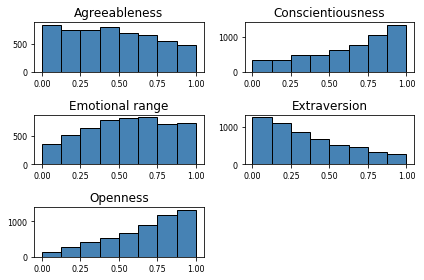

In [66]:
pers.hist(bins=8, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout();

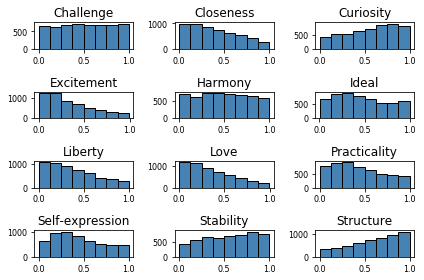

In [67]:
needs.hist(bins=8, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout();

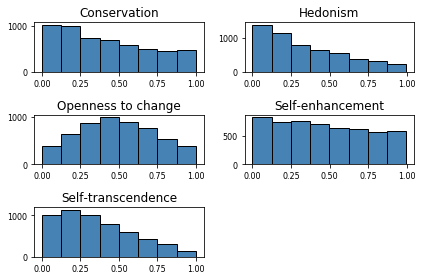

In [68]:
values.hist(bins=8, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout();

### Correlation Matrix

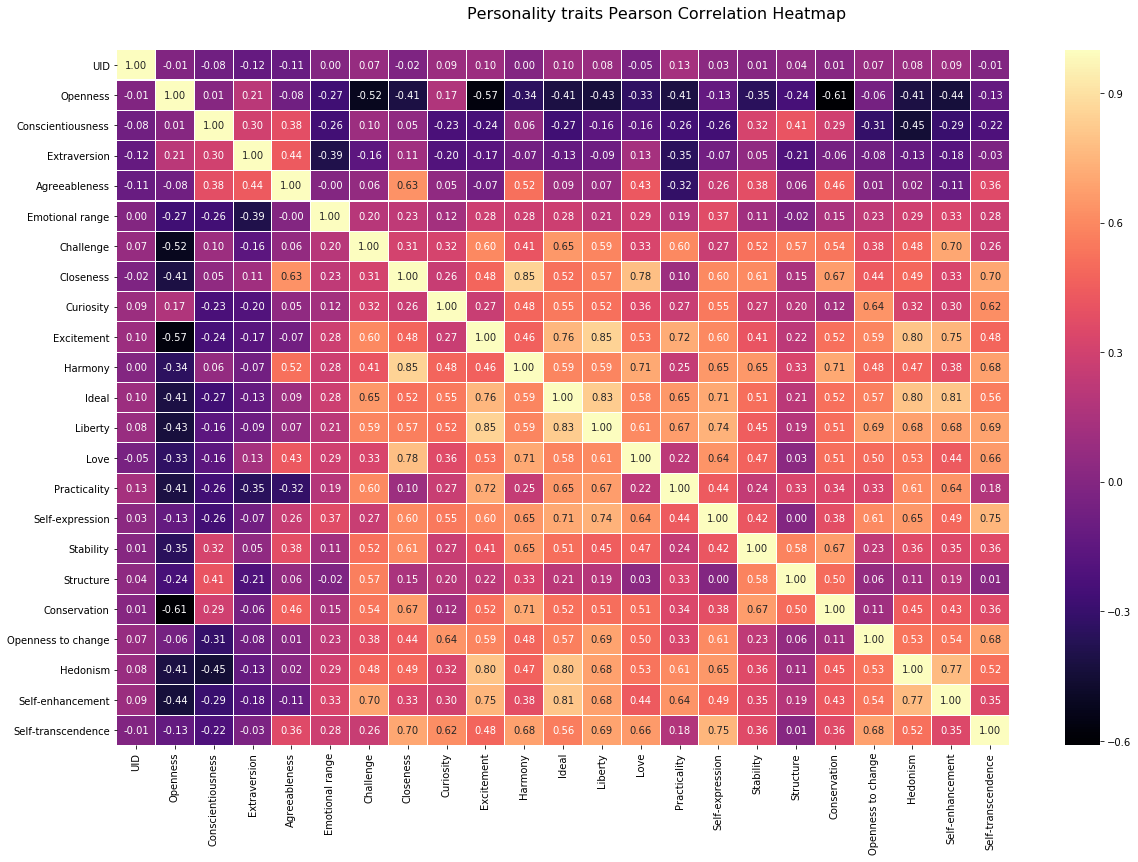

In [69]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize=(20, 12))
corr = profiles.corr(method='pearson')
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="magma",fmt='.2f',
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
t= fig.suptitle('Personality traits Pearson Correlation Heatmap', fontsize=16)

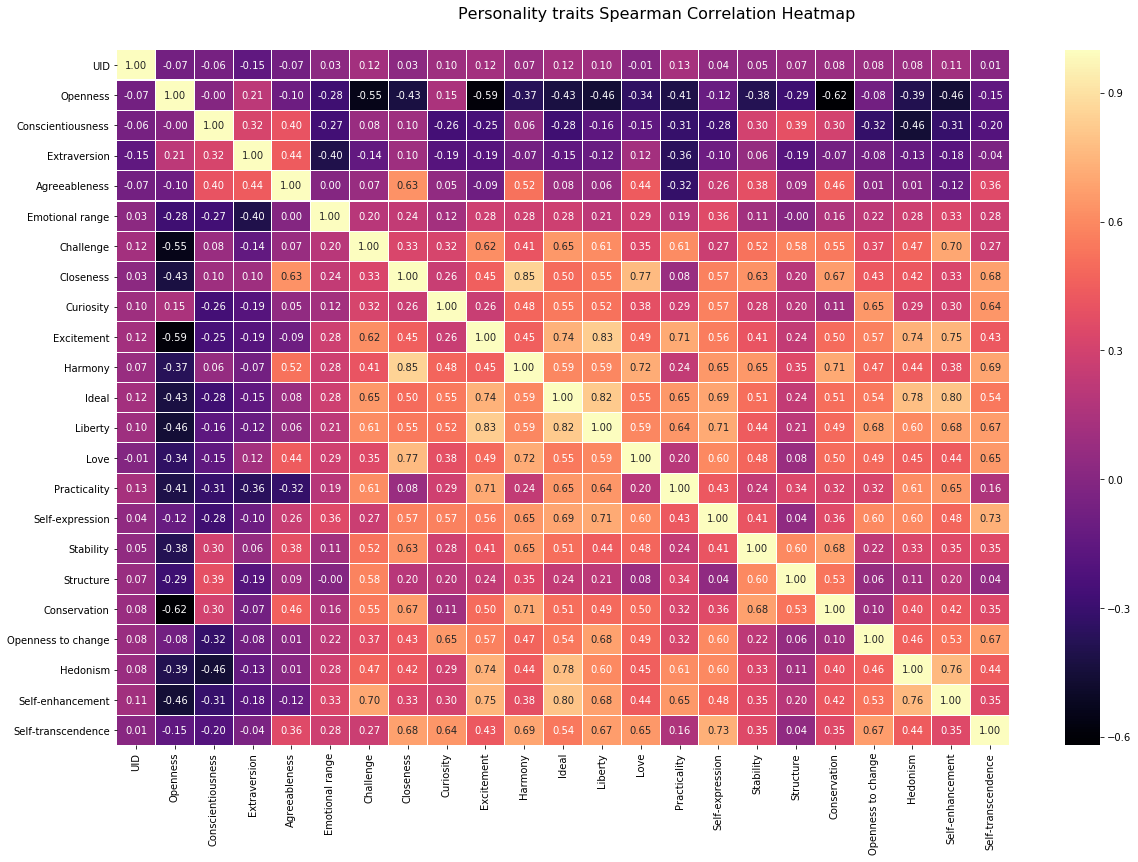

In [70]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize=(20, 12))
corr = profiles.corr(method='spearman')
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="magma",fmt='.2f',
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
t= fig.suptitle('Personality traits Spearman Correlation Heatmap', fontsize=16)

### Pairwise plots

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


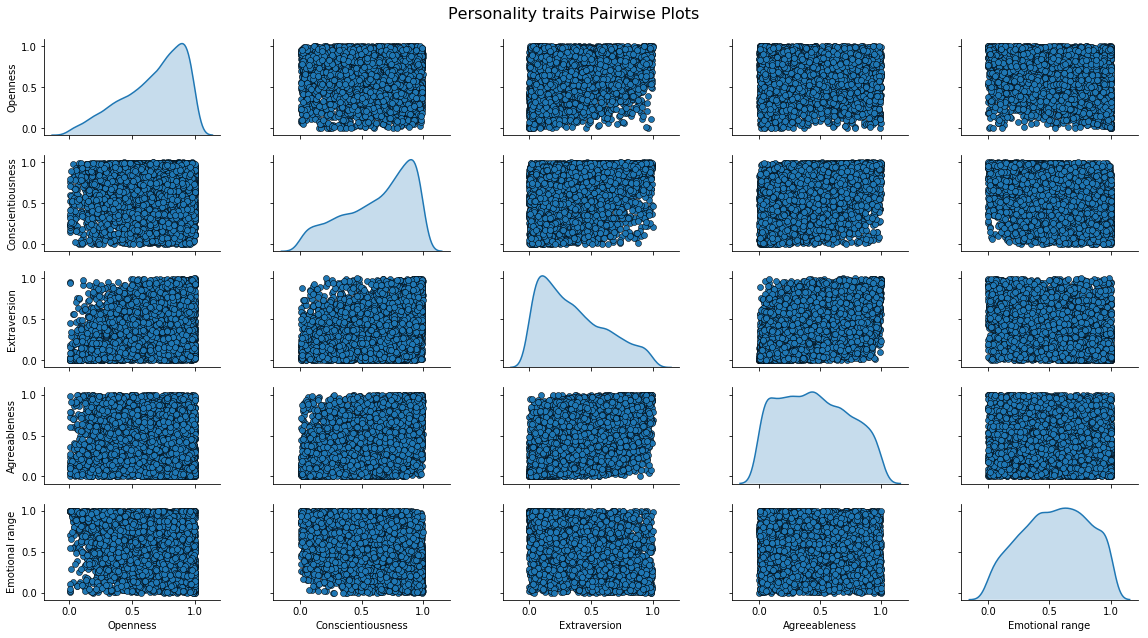

In [71]:
pp = sns.pairplot(pers, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 

fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Personality traits Pairwise Plots', fontsize=16)

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


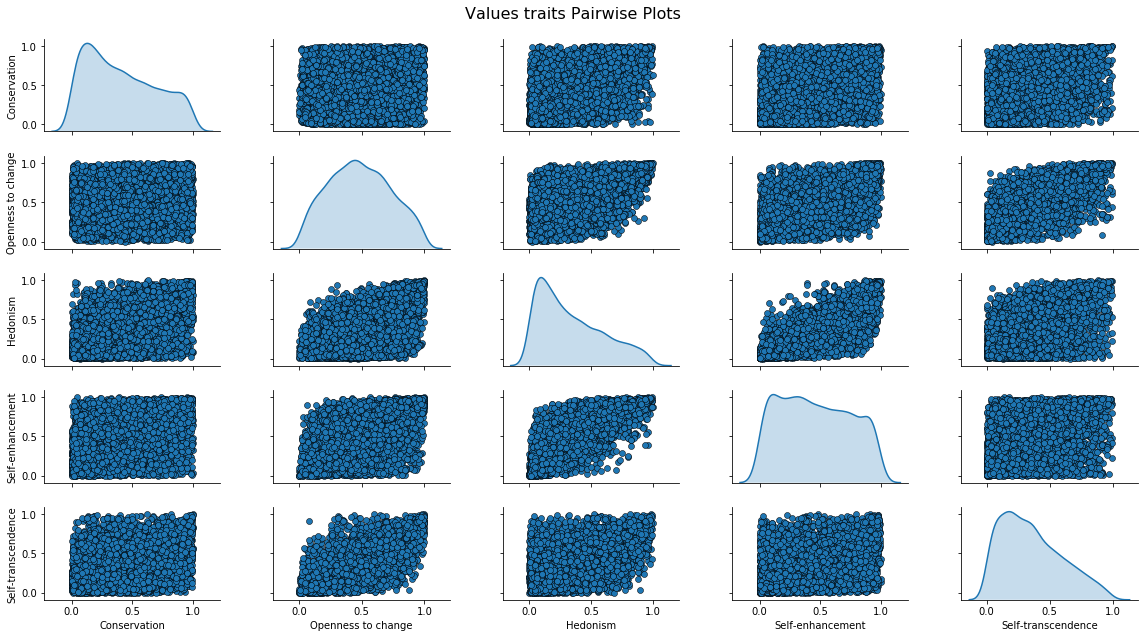

In [72]:
pp = sns.pairplot(values, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 

fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Values traits Pairwise Plots', fontsize=16)

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


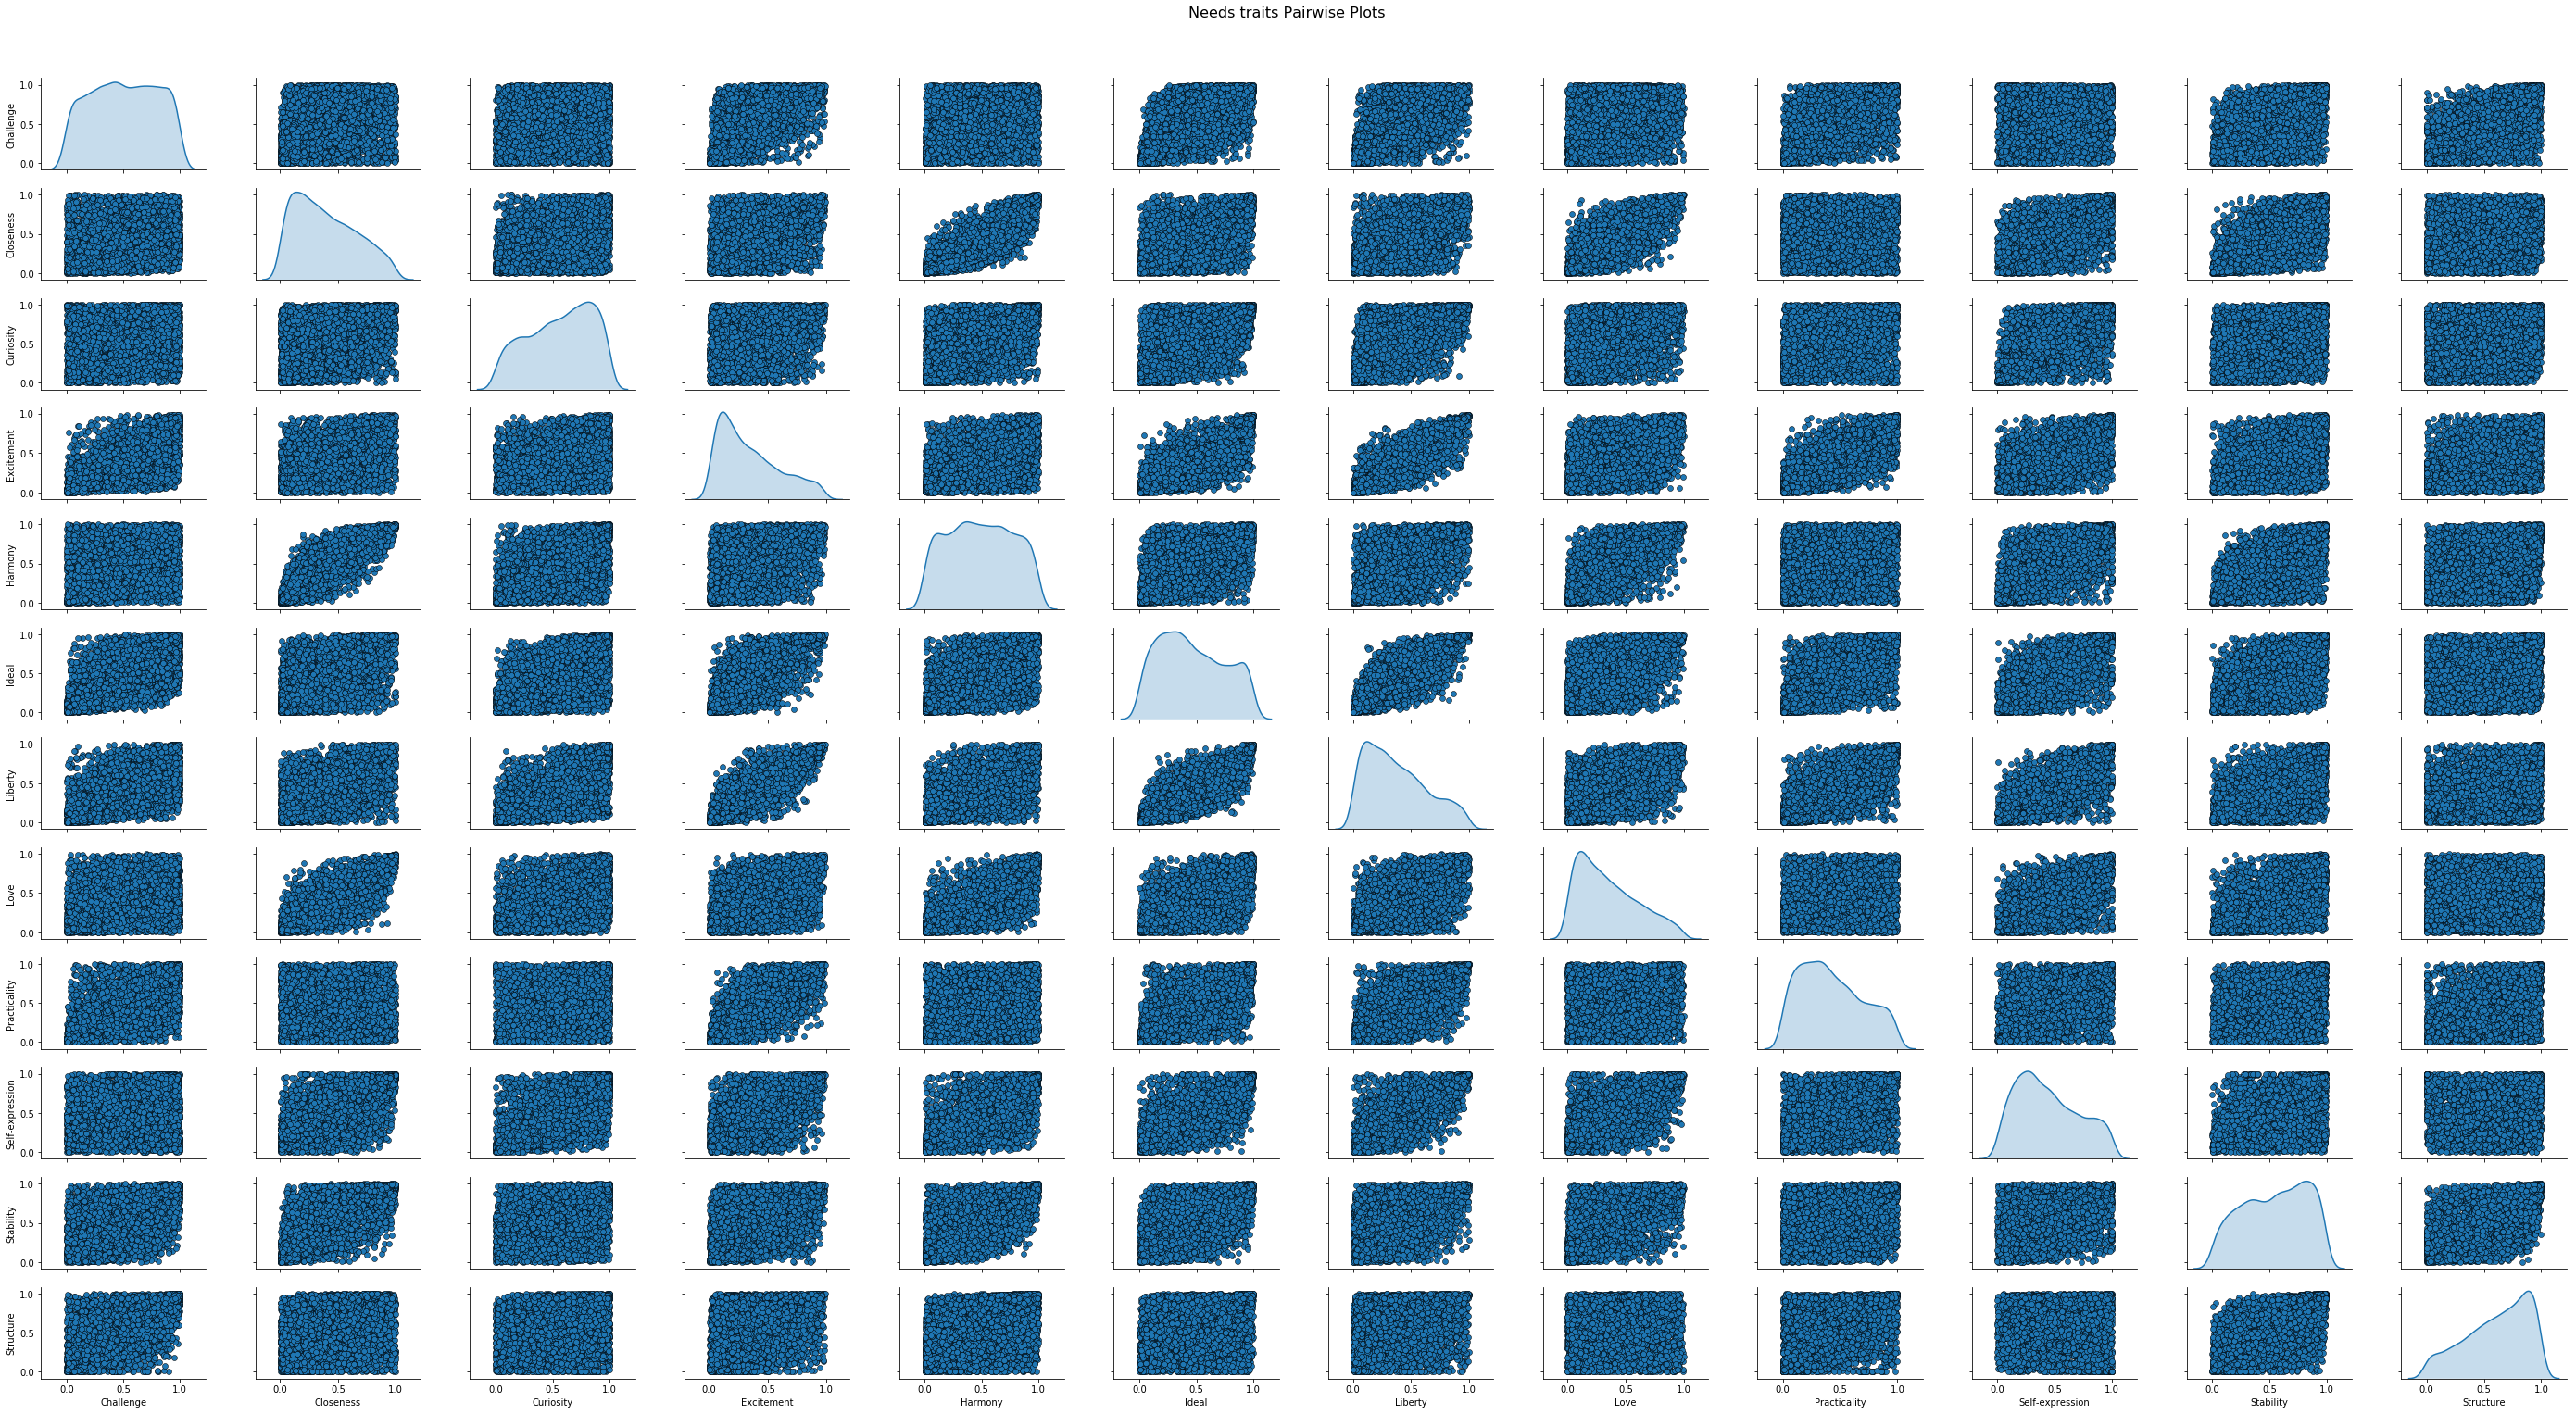

In [73]:
pp = sns.pairplot(needs, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 

fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Needs traits Pairwise Plots', fontsize=16)

### Box plots

In [74]:
def boxplot(param, data, ax=None):
    if not ax:
        fig, (ax) = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle('A box plot', fontsize=14)

    sns.boxplot(data[param],  ax=ax, orient='v', color='coral')
    ax.set_xlabel("{:s}".format(param),size = 12,alpha=0.8)
    ax.set_ylabel("",size = 12,alpha=0.8)

In [75]:
trait_columns

{'needs': ['Challenge',
  'Closeness',
  'Curiosity',
  'Excitement',
  'Harmony',
  'Ideal',
  'Liberty',
  'Love',
  'Practicality',
  'Self-expression',
  'Stability',
  'Structure'],
 'personality': ['Openness',
  'Conscientiousness',
  'Extraversion',
  'Agreeableness',
  'Emotional range'],
 'values': ['Conservation',
  'Openness to change',
  'Hedonism',
  'Self-enhancement',
  'Self-transcendence']}

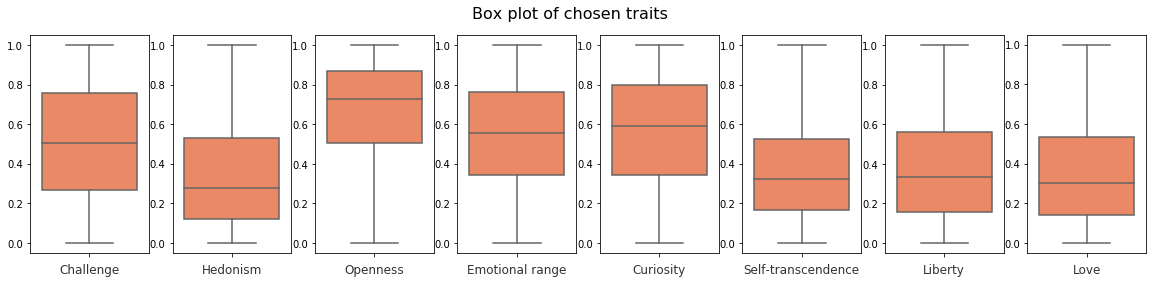

In [76]:
some_params = ['Challenge', 'Hedonism', 'Openness', 'Emotional range', 'Curiosity', 'Self-transcendence', 'Liberty', 'Love']
fig, axs = plt.subplots(1, len(some_params), figsize=(20, 4))
fig.suptitle('Box plot of chosen traits', fontsize=16)

for i, trait in enumerate(some_params):
    boxplot(trait, profiles, axs[i])

`One has acquired an initial understanding of the data and its interdependencies. Now it's time to advance to data modeling.`